<a href="https://colab.research.google.com/github/bulat15g/Course_work/blob/master/Cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import data and libs
В данном пункте выполняется подключение к гугл диску и импортирование данных

#### Import data from google drive
В данном пункте происходит соединение с гугл диском и вывод директорий окружения

In [1]:
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')
data_folder = "/content/drive/My Drive/datasets/voice_emotion"

!ls "/content/drive/My Drive/datasets/voice_emotion"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24


#### import libs
установка и импорт необходимых для работы библиотек

In [126]:
import librosa
!pip install soundfile
import soundfile
import os, glob, pickle
import numpy as np
import statsmodels.stats.api as sms

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout,Input,Flatten,Lambda,Embedding
from keras import backend as K
from keras.optimizers import RMSprop
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split

import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import seaborn as sns


### Extracting feautures, split and augmentating data

#### extracting features from wav
Реализована функция извлечения признаков из аудиофаилов
В зависимости от булевых переменных меняются извлекаемвые признаки или добавляются шумы

In [154]:
def extract_feature(file_name, mfcc, chroma, mel,add_noise = False):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if add_noise:
          noise = np.random.randn(len(X))
          X = X + noise * 0.001
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        return result

Создание словаря эмоций и тех эмоций, с которыми будет произведена работа

In [155]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

Пофаиловое чтение и извлечение признаков

In [5]:
x,y=[],[]
file_counter = 0
for file in glob.glob(data_folder + "/Actor_*//*.wav"):
    file_name=os.path.basename(file)
    emotion=emotions[file_name.split("-")[2]]
    if emotion not in observed_emotions:
        continue
    feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    file_counter+=1
    if file_counter%50 == 0: print(file_counter,end = " ")

x=np.array(x)
y=np.array(y)

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 

Вывод размерностей получившихся признаков 

In [6]:
x.shape

(768, 180)

##### data visualization
Отрисовка гистограммы распределения признаков

(array([192.,   0.,   0., 192.,   0.,   0., 192.,   0.,   0., 192.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

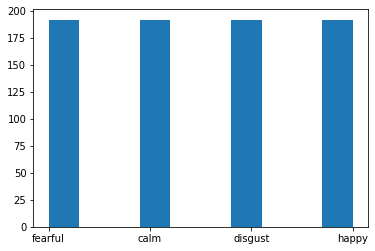

In [7]:
plt.hist(y)

#### Encode and split to 3 parts
изменение целевых признаков в зависимости от типа принимаемых y

In [8]:
encoder = LabelEncoder()
transfomed_label = encoder.fit_transform(y)
y_lab = transfomed_label
encoder_bin = LabelBinarizer()
transfomed_label = encoder_bin.fit_transform(y)
y_bin = transfomed_label

Приведение к необходимому numpy типу


In [156]:
y=np.array(y)
y_bin = np.array(y_bin)
print(y_bin)

[[0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 ...
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]]


В следующих 3 ячейках

Сделано разбиение на (обучение и тест) и контрольную выборку в соотношении 90/10.

Сделано разбиение набора (обучение и тест) на обучение и тест в соотношении 85/15.

Были выведены формы получившихся массивов для проверки

In [101]:
random_num = 2

X_train_test, X_control, y_train_test, y_control = train_test_split(x, y_lab, test_size=0.10,random_state = random_num)
X_train_test_bin, X_control_bin, y_train_test_bin, y_control_bin = train_test_split(x, y_bin, test_size=0.10,random_state = random_num)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.15,random_state = random_num)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_train_test, y_train_test_bin, test_size=0.15,random_state = random_num)

In [103]:
X_train.shape,X_test.shape,X_control.shape

((587, 180), (104, 180), (77, 180))

##### split visualization
Отрисовка получившихся разбиений

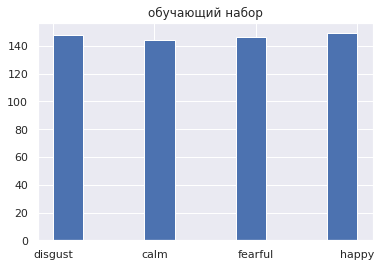

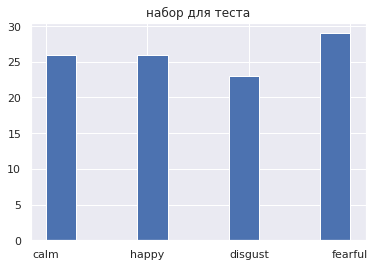

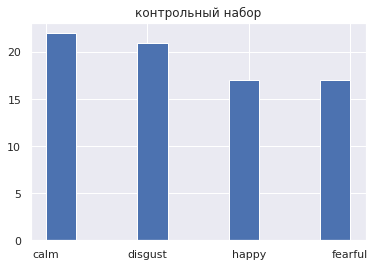

In [104]:
sns.set(rc={'figure.figsize':(6,4)})
plt.hist(encoder.inverse_transform(y_train),density=False,label=observed_emotions)
plt.title("обучающий набор")
plt.show()
plt.hist(encoder.inverse_transform(y_test),density=False,label=observed_emotions)
plt.title("набор для теста")
plt.show()
plt.hist(encoder.inverse_transform(y_control),density=False,label=observed_emotions)
plt.title("контрольный набор")
plt.show()

#### data augmentation
чтение данных, добавление шума и извлечение признаков

In [14]:
x_aug,y_aug=[],[]
file_counter = 0
for file in glob.glob(data_folder + "/Actor_*//*.wav"):
    file_name=os.path.basename(file)
    emotion=emotions[file_name.split("-")[2]]
    if emotion not in observed_emotions:
        continue
    feature=extract_feature(file, mfcc=True, chroma=True, mel=True,add_noise=True)
    x_aug.append(feature)
    y_aug.append(emotion)
    file_counter+=1
    if file_counter%50 == 0: print(file_counter,end = " ")

X_aug=np.array(x_aug)
y_aug=np.array(y_aug)
y_aug_label = encoder.transform(y_aug) 
y_aug_bin = encoder_bin.transform(y_aug)


50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 

### Initialize models

#### Model 1
Инициализация модели, обучение

In [24]:
def get_mod1(mod):
  # mod.add(Embedding(1, 1, input_length=180))
  mod.add(Dense(20, input_dim=180, activation='relu'))
  
  mod.add(Dropout(0.08))
  mod.add(Dense(20, activation='relu'))
  # mod.add(Dropout(0.07))
  mod.add(Dense(6, activation='relu'))
  # mod.add(Dense(5, activation='tanh'))
  mod.add(Dense(4, activation='softmax'))
  mod.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return mod


model1 = Sequential()
model1 = get_mod1(model1)
model1.fit(X_train, y_train, epochs=400, batch_size=32)

Epoch 1/400
587/587 [==============================] - 0s 222us/step - loss: 2.5384 - accuracy: 0.2164
Epoch 2/400
587/587 [==============================] - 0s 55us/step - loss: 1.5834 - accuracy: 0.2470
Epoch 3/400
587/587 [==============================] - 0s 47us/step - loss: 1.4746 - accuracy: 0.2470
Epoch 4/400
587/587 [==============================] - 0s 47us/step - loss: 1.4211 - accuracy: 0.2521
Epoch 5/400
587/587 [==============================] - 0s 48us/step - loss: 1.4260 - accuracy: 0.2487
Epoch 6/400
587/587 [==============================] - 0s 47us/step - loss: 1.3949 - accuracy: 0.2487
Epoch 7/400
587/587 [==============================] - 0s 49us/step - loss: 1.3886 - accuracy: 0.2504
Epoch 8/400
587/587 [==============================] - 0s 48us/step - loss: 1.4014 - accuracy: 0.2589
Epoch 9/400
587/587 [==============================] - 0s 47us/step - loss: 1.3878 - accuracy: 0.2538
Epoch 10/400
587/587 [==============================] - 0s 46us/step - loss: 1.38

In [25]:
model1.evaluate(X_test, y_test)

104/104 [==============================] - 0s 253us/step


[1.5484943573291485, 0.6057692170143127]

#### Model 2
Инициализация модели, обучение

In [30]:
def get_mod2(model2):
  model2.add(Dense(30, input_dim=180, activation='relu'))
  model2.add(Dropout(0.3))
  model2.add(Dense(20, activation='relu'))
  model2.add(Dropout(0.2))
  # model2.add(Dense(20, activation='relu'))
  # model2.add(Dropout(0.2))
  model2.add(Dense(10, activation='relu'))
  model2.add(Dense(10, activation='tanh'))
  model2.add(Dense(6, activation='relu'))
  model2.add(Dense(4, activation='softmax'))
  model2.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2), optimizer='adam', metrics=['accuracy'])
  return model2
  
model2 = Sequential()
model2 = get_mod2(model2)
model2.fit(X_train_bin, y_train_bin, epochs=300, batch_size=32)

Epoch 1/300
587/587 [==============================] - 0s 378us/step - loss: 0.6404 - accuracy: 0.2572
Epoch 2/300
587/587 [==============================] - 0s 58us/step - loss: 0.6317 - accuracy: 0.2589
Epoch 3/300
587/587 [==============================] - 0s 58us/step - loss: 0.6248 - accuracy: 0.3066
Epoch 4/300
587/587 [==============================] - 0s 57us/step - loss: 0.6249 - accuracy: 0.2658
Epoch 5/300
587/587 [==============================] - 0s 58us/step - loss: 0.6233 - accuracy: 0.2300
Epoch 6/300
587/587 [==============================] - 0s 55us/step - loss: 0.6213 - accuracy: 0.2470
Epoch 7/300
587/587 [==============================] - 0s 57us/step - loss: 0.6225 - accuracy: 0.2589
Epoch 8/300
587/587 [==============================] - 0s 57us/step - loss: 0.6234 - accuracy: 0.2487
Epoch 9/300
587/587 [==============================] - 0s 56us/step - loss: 0.6214 - accuracy: 0.2334
Epoch 10/300
587/587 [==============================] - 0s 62us/step - loss: 0.61

In [35]:
model2.evaluate(X_test, y_test)

104/104 [==============================] - 0s 73us/step


[2.0487567461453953, 0.2884615361690521]

#### Model 2 without label smoothing
Инициализация модели, обучение

In [36]:
def get_mod2_5(model2_5):
  model2_5.add(Dense(30, input_dim=180, activation='relu'))
  model2_5.add(Dropout(0.2))
  model2_5.add(Dense(20, activation='relu'))
  model2_5.add(Dropout(0.2))
  model2_5.add(Dense(20, activation='relu'))
  model2_5.add(Dropout(0.1))
  model2_5.add(Dense(15, activation='relu'))
  model2_5.add(Dense(10, activation='relu'))
  model2_5.add(Dense(10, activation='tanh'))
  model2_5.add(Dense(6, activation='tanh'))
  model2_5.add(Dense(4, activation='softmax'))
  model2_5.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
  return model2_5

model2_5 = Sequential()
model2_5 = get_mod2_5(model2_5)
model2_5.fit(X_train_bin, y_train_bin, epochs=200, batch_size=32)

Epoch 1/200
587/587 [==============================] - 0s 452us/step - loss: 0.5743 - accuracy: 0.2589
Epoch 2/200
587/587 [==============================] - 0s 60us/step - loss: 0.5703 - accuracy: 0.2351
Epoch 3/200
587/587 [==============================] - 0s 59us/step - loss: 0.5639 - accuracy: 0.2675
Epoch 4/200
587/587 [==============================] - 0s 62us/step - loss: 0.5647 - accuracy: 0.2760
Epoch 5/200
587/587 [==============================] - 0s 59us/step - loss: 0.5681 - accuracy: 0.2436
Epoch 6/200
587/587 [==============================] - 0s 59us/step - loss: 0.5645 - accuracy: 0.2470
Epoch 7/200
587/587 [==============================] - 0s 59us/step - loss: 0.5625 - accuracy: 0.2658
Epoch 8/200
587/587 [==============================] - 0s 62us/step - loss: 0.5634 - accuracy: 0.2351
Epoch 9/200
587/587 [==============================] - 0s 60us/step - loss: 0.5635 - accuracy: 0.2266
Epoch 10/200
587/587 [==============================] - 0s 60us/step - loss: 0.56

In [37]:
model2_5.evaluate(X_test, y_test)

104/104 [==============================] - 0s 384us/step


[3.177836564870981, 0.3076923191547394]

#### Model 3
Сиамская модель, было предпринято множество попыток, но успешной работы добиться не удалось

In [145]:
num_classes = 4
epochs = 20

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    # x = Flatten()(input)
    x = input
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [146]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = (X_train,y_train),(X_test, y_test)
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Train on 1144 samples, validate on 176 samples
Epoch 1/20
1144/1144 [==============================] - 0s 262us/step - loss: 2668.6851 - accuracy: 0.5003 - val_loss: 45.2225 - val_accuracy: 0.5000
Epoch 2/20
1144/1144 [==============================] - 0s 48us/step - loss: 420.0961 - accuracy: 0.4998 - val_loss: 13.5696 - val_accuracy: 0.4831
Epoch 3/20
1144/1144 [==============================] - 0s 44us/step - loss: 135.9761 - accuracy: 0.4990 - val_loss: 6.8211 - val_accuracy: 0.4505
Epoch 4/20
1144/1144 [==============================] - 0s 45us/step - loss: 55.5465 - accuracy: 0.5012 - val_loss: 2.5796 - val_accuracy: 0.5104
Epoch 5/20
1144/1144 [==============================] - 0s 53us/step - loss: 35.0530 - accuracy: 0.4980 - val_loss: 1.3618 - val_accuracy: 0.5208
Epoch 6/20
1144/1144 [==============================] - 0s 46us/step - loss: 22.7929 - accuracy: 0.4994 - val_loss: 0.7061 - val_accuracy: 0.4609
Epoch 7/20
1144/1144 [==============================] - 0s 43us/step -

#### Model 1 with data augmentation
Инициализация модели, обучение. обучающие данные сконкатенированы с обогащенной выборкой

In [38]:
model1_aug = Sequential()
model1_aug = get_mod1(model1_aug)
model1_aug.fit(np.concatenate((X_train,X_aug),axis=0), np.concatenate((y_train,y_aug_label),axis=0), epochs=500, batch_size=32)
# model1_aug.fit(X_train, y_train, epochs=300, batch_size=32)
# model1_aug.fit(X_aug, y_aug_label, epochs=75, batch_size=32)

Epoch 1/500
1355/1355 [==============================] - 0s 118us/step - loss: 12.2863 - accuracy: 0.2554
Epoch 2/500
1355/1355 [==============================] - 0s 40us/step - loss: 2.3291 - accuracy: 0.2568
Epoch 3/500
1355/1355 [==============================] - 0s 44us/step - loss: 1.6024 - accuracy: 0.2435
Epoch 4/500
1355/1355 [==============================] - 0s 42us/step - loss: 1.4484 - accuracy: 0.2517
Epoch 5/500
1355/1355 [==============================] - 0s 50us/step - loss: 1.4240 - accuracy: 0.2502
Epoch 6/500
1355/1355 [==============================] - 0s 45us/step - loss: 1.4167 - accuracy: 0.2494
Epoch 7/500
1355/1355 [==============================] - 0s 45us/step - loss: 1.3992 - accuracy: 0.2384
Epoch 8/500
1355/1355 [==============================] - 0s 47us/step - loss: 1.3910 - accuracy: 0.2546
Epoch 9/500
1355/1355 [==============================] - 0s 45us/step - loss: 1.3947 - accuracy: 0.2362
Epoch 10/500
1355/1355 [==============================] - 0s 4

In [39]:
model1_aug.evaluate(X_test, y_test)

104/104 [==============================] - 0s 241us/step


[1.0047970093213594, 0.7788461446762085]

Инициализация модели, обучение. обучающие данные сконкатенированы с обогащенной выборкой

In [40]:
model2_aug = Sequential()
model2_aug = get_mod2(model2_aug)
model2_aug.fit(np.concatenate((X_train,X_aug),axis=0), np.concatenate((y_train_bin,y_aug_bin)), epochs=200, batch_size=32)

Epoch 1/200
1355/1355 [==============================] - 0s 178us/step - loss: 0.7611 - accuracy: 0.2583
Epoch 2/200
1355/1355 [==============================] - 0s 52us/step - loss: 0.6678 - accuracy: 0.2561
Epoch 3/200
1355/1355 [==============================] - 0s 58us/step - loss: 0.6381 - accuracy: 0.2561
Epoch 4/200
1355/1355 [==============================] - 0s 51us/step - loss: 0.6276 - accuracy: 0.2672
Epoch 5/200
1355/1355 [==============================] - 0s 53us/step - loss: 0.6266 - accuracy: 0.2428
Epoch 6/200
1355/1355 [==============================] - 0s 52us/step - loss: 0.6230 - accuracy: 0.2531
Epoch 7/200
1355/1355 [==============================] - 0s 51us/step - loss: 0.6207 - accuracy: 0.2768
Epoch 8/200
1355/1355 [==============================] - 0s 51us/step - loss: 0.6203 - accuracy: 0.2708
Epoch 9/200
1355/1355 [==============================] - 0s 51us/step - loss: 0.6209 - accuracy: 0.2708
Epoch 10/200
1355/1355 [==============================] - 0s 55

In [141]:
model2_aug.evaluate(X_test, y_test)

104/104 [==============================] - 0s 140us/step


[2.1740520550654483, 0.2884615361690521]

#### Model 2 without label smoothing, augmentation
Инициализация модели, обучение. обучающие данные сконкатенированы с обогащенной выборкой

In [48]:
model2_5aug = Sequential()
model2_5aug = get_mod2_5(model2_5aug)
model2_5aug.fit(np.concatenate((X_train,X_aug),axis=0), np.concatenate((y_train_bin,y_aug_bin)), epochs=100, batch_size=32)

Epoch 1/100
1355/1355 [==============================] - 0s 227us/step - loss: 0.5906 - accuracy: 0.2494
Epoch 2/100
1355/1355 [==============================] - 0s 55us/step - loss: 0.5713 - accuracy: 0.2413
Epoch 3/100
1355/1355 [==============================] - 0s 59us/step - loss: 0.5654 - accuracy: 0.2531
Epoch 4/100
1355/1355 [==============================] - 0s 59us/step - loss: 0.5641 - accuracy: 0.2590
Epoch 5/100
1355/1355 [==============================] - 0s 58us/step - loss: 0.5637 - accuracy: 0.2443
Epoch 6/100
1355/1355 [==============================] - 0s 59us/step - loss: 0.5628 - accuracy: 0.2642
Epoch 7/100
1355/1355 [==============================] - 0s 60us/step - loss: 0.5616 - accuracy: 0.2745
Epoch 8/100
1355/1355 [==============================] - 0s 61us/step - loss: 0.5624 - accuracy: 0.2708
Epoch 9/100
1355/1355 [==============================] - 0s 60us/step - loss: 0.5616 - accuracy: 0.2723
Epoch 10/100
1355/1355 [==============================] - 0s 61

In [49]:
model2_5aug.evaluate(X_test, y_test)

104/104 [==============================] - 0s 371us/step


[3.188149929046631, 0.29807692766189575]

### Интерпретация признаков в представлении 
Реализована функция получения активаций нейронов на данных

In [50]:
def get_activations(model, layer, X_batch):
    activations_f = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
    activations = activations_f((X_batch, False))
    return activations

#### Model1
Визуализированы двумерные представления с помощью метода t-sne

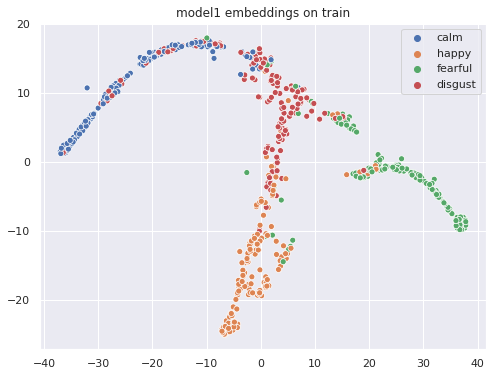

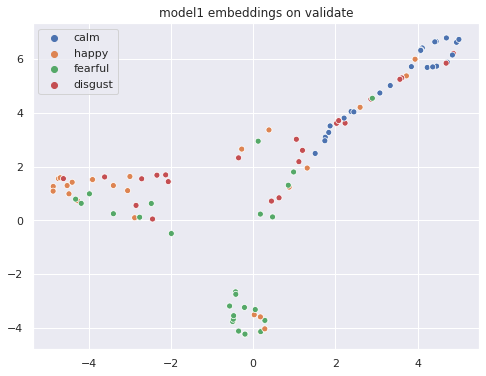

In [118]:
mod = [model1,"model1"]

tsne = TSNE()
sns.set(rc={'figure.figsize':(8,6)})
plt.title(mod[1]+" embeddings on train")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_train)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_train), legend='full',hue_order=observed_emotions)
plt.show()
plt.title(mod[1]+" embeddings on validate")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_test)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_test), legend='full',hue_order=observed_emotions)



#### Model1 augmentation
Визуализированы двумерные представления с помощью метода t-sne

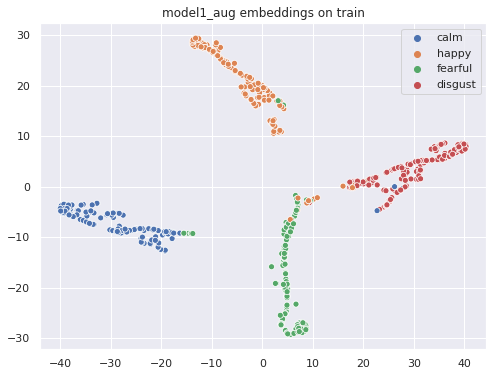

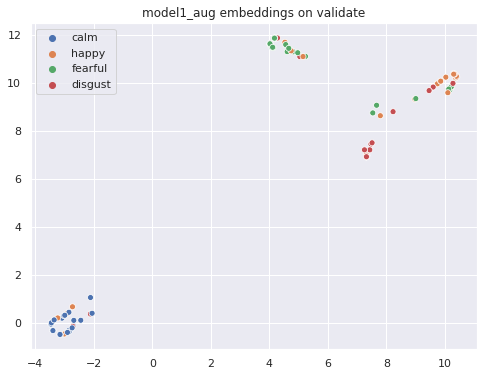

In [119]:
mod = [model1_aug,"model1_aug"]

tsne = TSNE()
sns.set(rc={'figure.figsize':(8,6)})
plt.title(mod[1]+" embeddings on train")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_train)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_train), legend='full',hue_order=observed_emotions)
plt.show()
plt.title(mod[1]+" embeddings on validate")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_test)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_test), legend='full',hue_order=observed_emotions)



#### model 2
Визуализированы двумерные представления с помощью метода t-sne

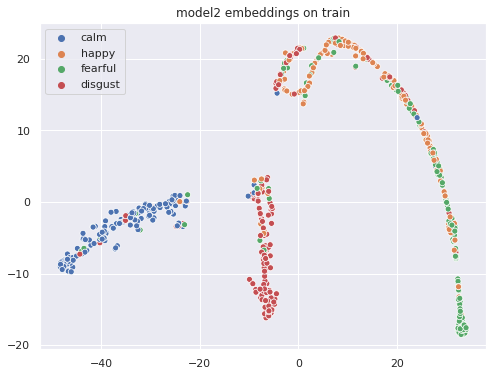

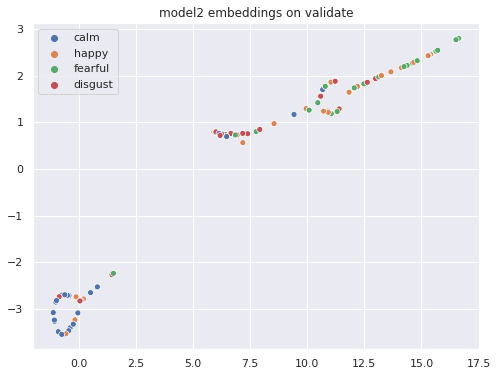

In [120]:
mod = [model2,"model2"]

tsne = TSNE()
sns.set(rc={'figure.figsize':(8,6)})
plt.title(mod[1]+" embeddings on train")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-2],X_train)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_train), legend='full',hue_order=observed_emotions)
plt.show()
plt.title(mod[1]+" embeddings on validate")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_test)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_test), legend='full',hue_order=observed_emotions)



#### model 2 aug
Визуализированы двумерные представления с помощью метода t-sne

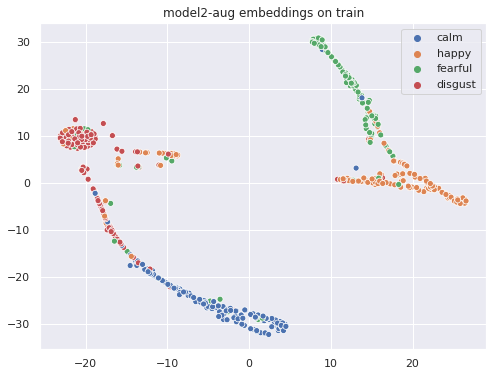

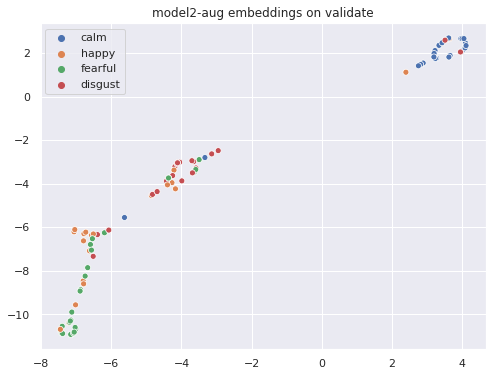

In [121]:
mod = [model2_aug,"model2-aug"]

tsne = TSNE()
sns.set(rc={'figure.figsize':(8,6)})
plt.title(mod[1]+" embeddings on train")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_train)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_train), legend='full',hue_order=observed_emotions)
plt.show()
plt.title(mod[1]+" embeddings on validate")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_test)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_test), legend='full',hue_order=observed_emotions)

#### model 2 without smoothing
Визуализированы двумерные представления с помощью метода t-sne

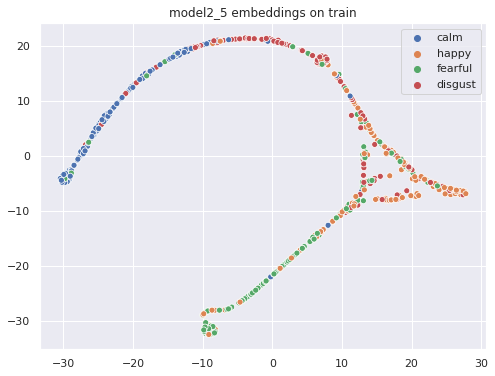

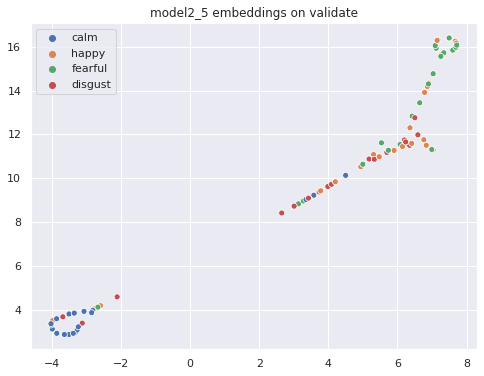

In [122]:
mod = [model2_5,"model2_5"]

tsne = TSNE()
sns.set(rc={'figure.figsize':(8,6)})
plt.title(mod[1]+" embeddings on train")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_train)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_train), legend='full',hue_order=observed_emotions)
plt.show()
plt.title(mod[1]+" embeddings on validate")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_test)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_test), legend='full',hue_order=observed_emotions)

#### model 2 without smoothing aug
Визуализированы двумерные представления с помощью метода t-sne

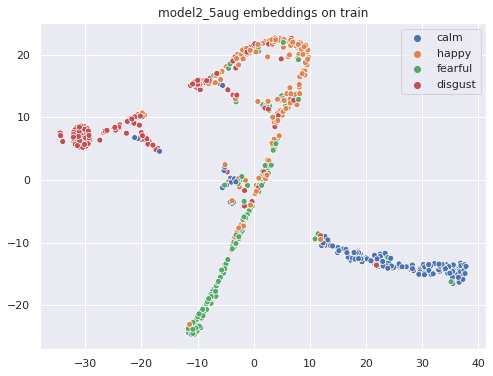

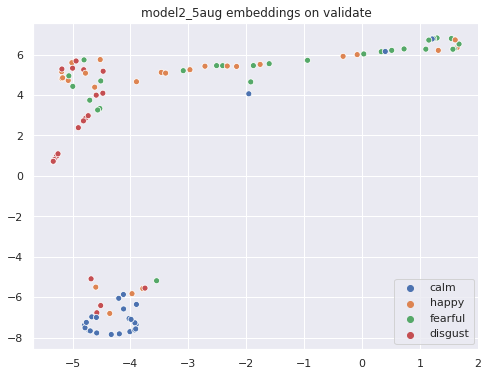

In [123]:
mod = [model2_5aug,"model2_5aug"]

tsne = TSNE()
sns.set(rc={'figure.figsize':(8,6)})
plt.title(mod[1]+" embeddings on train")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_train)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_train), legend='full',hue_order=observed_emotions)
plt.show()
plt.title(mod[1]+" embeddings on validate")
X_embedded = tsne.fit_transform(get_activations(mod[0],mod[0].layers[-1],X_test)[0])
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=encoder.inverse_transform(y_test), legend='full',hue_order=observed_emotions)

### test models

#### Test
реализация бутстрепа и сравнение показателей точности методов на тестовой выборке

In [150]:
count_objects = 15
N = 30;

results = []
 
models = [model1,model1_aug]
model_names = ["model1","model1_aug"]
for c, model in enumerate(models):
  local = []
  for i in range(N):
    choose = np.random.choice(list(range(X_test.shape[0])),size=count_objects)
    local.append(model.evaluate(X_test[choose],y_test[choose])[1])
  results.append((model_names[c],local))

models = [model2,model2_aug,model2_5,model2_5aug]
model_names = ["model2","model2_aug","model2_5","model2_5aug"]
for c, model in enumerate(models):
  local = []
  for i in range(N):
    choose = np.random.choice(list(range(X_test_bin.shape[0])),size=count_objects)
    local.append(model.evaluate(X_test_bin[choose],y_test_bin[choose])[1])
  results.append((model_names[c],local))



15/15 [==============================] - 0s 77us/step


Вывод полученных значений в удобном виде

In [152]:
for i in results:
  print(i[0],"%.3f"% np.mean(i[1]),"%.3f"% sms.DescrStatsW(i[1]).tconfint_mean()[0],"%.3f"% sms.DescrStatsW(i[1]).tconfint_mean()[1])

model1 0.616 0.568 0.663
model1_aug 0.762 0.723 0.802
model2 0.631 0.587 0.675
model2_aug 0.718 0.682 0.754
model2_5 0.584 0.542 0.627
model2_5aug 0.627 0.583 0.670


#### Train
реализация бутстрепа и сравнение показателей точности методов на тестовой выборке

In [132]:
count_objects = 15
N = 30;

results = []
 
models = [model1,model1_aug]
model_names = ["model1","model1_aug"]
for c, model in enumerate(models):
  local = []
  for i in range(N):
    choose = np.random.choice(list(range(X_train.shape[0])),size=count_objects)
    local.append(model.evaluate(X_train[choose],y_train[choose])[1])
  results.append((model_names[c],local))

models = [model2,model2_aug,model2_5,model2_5aug]
model_names = ["model2","model2_aug","model2_5","model2_5aug"]
for c, model in enumerate(models):
  local = []
  for i in range(N):
    choose = np.random.choice(list(range(X_train_bin.shape[0])),size=count_objects)
    local.append(model.evaluate(X_train_bin[choose],y_train_bin[choose])[1])
  results.append((model_names[c],local))



15/15 [==============================] - 0s 48us/step


Вывод полученных значений в удобном виде

In [133]:
for i in results:
  print(i[0],"%.3f"% np.mean(i[1]),"%.3f"% sms.DescrStatsW(i[1]).tconfint_mean()[0],"%.3f"% sms.DescrStatsW(i[1]).tconfint_mean()[1])

model1 0.844 0.810 0.879
model1_aug 0.938 0.918 0.957
model2 0.740 0.691 0.789
model2_aug 0.840 0.797 0.883
model2_5 0.680 0.630 0.730
model2_5aug 0.780 0.740 0.820


#### Control

Получение показателя точности у выборанного кандидата на контрольной выборке

In [153]:
count_objects = 15
N = 30;

results = []
 
models = [model1_aug]
model_names = ["model1_aug"]
for c, model in enumerate(models):
  local = []
  for i in range(N):
    choose = np.random.choice(list(range(X_validate.shape[0])),size=count_objects)
    local.append(model.evaluate(X_validate[choose],y_validate[choose])[1])
  results.append((model_names[c],local))

# models = [model2,model2_aug,model2_5,model2_5aug]
# model_names = ["model2","model2_aug","model2_5","model2_5aug"]
# for c, model in enumerate(models):
#   local = []
#   for i in range(N):
#     choose = np.random.choice(list(range(X_validate_bin.shape[0])),size=count_objects)
#     local.append(model.evaluate(X_validate_bin[choose],y_validate_bin[choose])[1])
#   results.append((model_names[c],local))



15/15 [==============================] - 0s 82us/step


Вывод полученных значений в удобном виде

In [144]:
for i in results:
  print(i[0],"%.3f"% np.mean(i[1]),"%.3f"% sms.DescrStatsW(i[1]).tconfint_mean()[0],"%.3f"% sms.DescrStatsW(i[1]).tconfint_mean()[1])

model1_aug 0.831 0.795 0.867
